# Movie Recommendation System
Students: Will Bennett, James Meredith

Instructor: David Elliot

Active Project Dates: May 29th - June 2nd

In [3]:
# Standard imports
import pandas as pd
import numpy as np
import math as math
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Sklearn
from sklearn.model_selection import train_test_split

# Custom Helper functions
from src.model_handling import SaveModel, ModelStorer

## Data Preperation & Cleaning

In [4]:
# Load data
df_movies = pd.read_csv('ml-latest-small/movies.csv')
df_tags = pd.read_csv('ml-latest-small/tags.csv')
df_ratings = pd.read_csv('ml-latest-small/ratings.csv')
# df_links = pd.read_csv('ml-latest-small/links.csv') I don't believe we will need to link to movies

We can check out each data table, we will start with movies

### Movies

In [5]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


We have an ID, a title, and a genre (separated by |)

Let's check for data types and missing data

In [6]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


It seems as if the movie data set is fairly clean, we can work with this

Next let's handle duplicates

In [7]:
#Check for duplicates
df_movies['title'].duplicated().value_counts()

False    9737
True        5
Name: title, dtype: int64

We will start by cleaning our data

In [8]:
df_movies_clean = df_movies
df_movies_clean.columns = df_movies.columns.str.lower()

In [9]:
# Investigate Duplcates
df_movies_clean = df_movies.drop_duplicates(subset='title', keep='first').reset_index(drop=True)
df_movies_clean

,movieid,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9732,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9733,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9734,193585,Flint (2017),Drama
9735,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


That has removed the duplicates, now let's handle genres

We can start by creating dummy variables for all the genres

In [10]:
movie_genres = df_movies_clean['genres'].str.get_dummies()

df_movies_clean = pd.concat([df_movies_clean, movie_genres], axis=1, join='inner')
df_movies_clean

,movieid,title,genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9732,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9733,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9734,193585,Flint (2017),Drama,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9735,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now that we've separated out the genres we can drop the genre column from movies

In [11]:
df_movies_clean = df_movies_clean.drop('genres', axis=1)

In [12]:
df_movies_clean

,movieid,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9732,193581,Black Butler: Book of the Atlantic (2017),0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9733,193583,No Game No Life: Zero (2017),0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9734,193585,Flint (2017),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9735,193587,Bungo Stray Dogs: Dead Apple (2018),0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We only need to keep movies with ratings

In [14]:
# df_movies_clean = df_movies_clean[df_movies_clean['movieid'].isin(df_ratings.movieid)].reset_index(drop=True)
df_movies_clean

,movieid,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9732,193581,Black Butler: Book of the Atlantic (2017),0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9733,193583,No Game No Life: Zero (2017),0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9734,193585,Flint (2017),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9735,193587,Bungo Stray Dogs: Dead Apple (2018),0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Tags

In [15]:
df_tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [16]:
df_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


It looks like we will need to clean the tags but there is no missing data.

We can likely drop the timestamp and user ID columns as well

In [17]:
df_tags_clean = df_tags
df_tags_clean.columns = df_tags_clean.columns.str.lower()
df_tags_clean = df_tags_clean.drop(columns=['userid', 'timestamp'], axis=1)
df_tags_clean['tag'] = df_tags_clean['tag'].str.lower()
df_tags_clean.head()

,movieid,tag
0,60756,funny
1,60756,highly quotable
2,60756,will ferrell
3,89774,boxing story
4,89774,mma


We will need to convert the tags to dummies

In [18]:
df_tags_clean = df_tags_clean.groupby('movieid')['tag'].apply(list).reset_index()
df_tags_clean

,movieid,tag
0,1,"[pixar, pixar, fun]"
1,2,"[fantasy, magic board game, robin williams, game]"
2,3,"[moldy, old]"
3,5,"[pregnancy, remake]"
4,7,[remake]
...,...,...
1567,183611,"[comedy, funny, rachel mcadams]"
1568,184471,"[adventure, alicia vikander, video game adapta..."
1569,187593,"[josh brolin, ryan reynolds, sarcasm]"
1570,187595,"[emilia clarke, star wars]"


In [19]:
movie_tags = df_tags_clean['tag'].explode().str.get_dummies().groupby(level=0).sum()
movie_tags

,"""artsy""",06 oscar nominated best movie - animation,1900s,1920s,1950s,1960s,1970s,1980s,1990s,2001-like,...,world war i,world war ii,writing,wrongful imprisonment,wry,younger men,zither,zoe kazan,zombies,zooey deschanel
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1567,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1568,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1569,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1570,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
df_tags_clean = pd.concat([df_tags_clean, movie_tags], axis=1, join='inner')
df_tags_clean

,movieid,tag,"""artsy""",06 oscar nominated best movie - animation,1900s,1920s,1950s,1960s,1970s,1980s,...,world war i,world war ii,writing,wrongful imprisonment,wry,younger men,zither,zoe kazan,zombies,zooey deschanel
0,1,"[pixar, pixar, fun]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,"[fantasy, magic board game, robin williams, game]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,"[moldy, old]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,"[pregnancy, remake]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7,[remake],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1567,183611,"[comedy, funny, rachel mcadams]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1568,184471,"[adventure, alicia vikander, video game adapta...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1569,187593,"[josh brolin, ryan reynolds, sarcasm]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1570,187595,"[emilia clarke, star wars]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
df_tags_clean = df_tags_clean.drop('tag', axis=1)
df_tags_clean

,movieid,"""artsy""",06 oscar nominated best movie - animation,1900s,1920s,1950s,1960s,1970s,1980s,1990s,...,world war i,world war ii,writing,wrongful imprisonment,wry,younger men,zither,zoe kazan,zombies,zooey deschanel
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1567,183611,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1568,184471,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1569,187593,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1570,187595,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Ratings

In [22]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [23]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [24]:
df_ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


This dataset is clean as well with no missing data, we may not need the timestamp column here

In [25]:
df_ratings_clean = df_ratings
df_ratings_clean.columns = df_ratings_clean.columns.str.lower()
df_ratings_clean = df_ratings_clean.drop('timestamp', axis=1)
df_ratings_clean.head()

,userid,movieid,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


We should only keep ratings for movies that we have genre data for

In [26]:
df_ratings_clean = df_ratings_clean[df_ratings_clean['movieid'].isin(df_movies_clean.movieid)].reset_index(drop=True)
df_ratings_clean

,userid,movieid,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100825,610,166534,4.0
100826,610,168248,5.0
100827,610,168250,5.0
100828,610,168252,5.0


In [27]:
df_ratings_clean = df_ratings_clean.pivot(index='userid', columns='movieid', values='rating').reset_index().fillna(0)
df_ratings_clean

movieid,userid,1,2,3,4,5,6,7,8,9,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
0,1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,606,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
606,607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,608,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,609,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Data Exploration

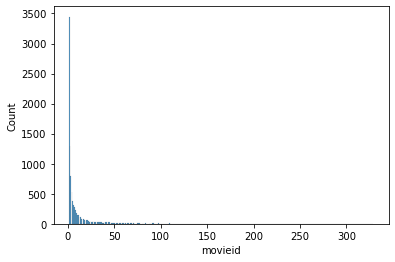

In [28]:
sns.histplot(df_ratings['movieid'].value_counts());

There is a long tail in movies that aren't rate, that's where a recommendation system can shine

Movie breakdown by genre

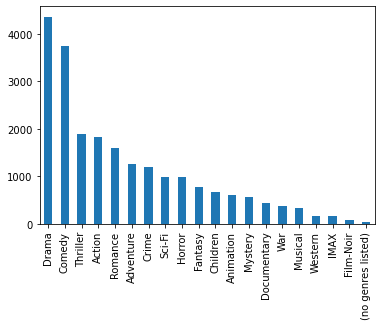

In [29]:
data = df_movies_clean.drop(['movieid', 'title'], axis=1).agg('sum').sort_values(ascending=False)

data.plot.bar();

## Modeling

### Cosign Similarity

In [68]:
# Imports required libraries for the model
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [70]:
df_ratings_clean = df_ratings
df_ratings_clean.columns = df_ratings_clean.columns.str.lower()
df_ratings_clean = df_ratings_clean.drop('timestamp', axis=1)
df_ratings_clean.head()

,userid,movieid,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


Preparing the Data Matrix

In [76]:
data_matrix = df_ratings_clean.pivot_table(index='userid', columns='movieid', values='rating')
data_matrix = data_matrix.fillna(0)  # Replace missing values with 0

In [77]:
data_matrix.head()

movieid,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userid,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
# Computes cosine similarity
similarity_matrix = cosine_similarity(data_matrix)

Generating Recommendations

In [92]:
# Assuming you want to recommend items to a target user with index "target_user_index"
target_user_index = 1

# Compute the similarity scores between the target user and all other users
user_similarities = similarity_matrix[target_user_index]

# Sort the similarity scores in descending order and get the indices of most similar users
most_similar_users_indices = np.argsort(user_similarities)[::-1]

# Generate recommendations based on the most similar users
recommendations = most_similar_users_indices[1:]  # Exclude the target user itself


In [105]:
# Top 5 Movie recommendations for user 1
top_5 = recommendations[:5]
top_5

array([365, 416, 377, 549, 188], dtype=int64)

In [104]:
# Uses recommendations to generate a list of movies to recommend
df_movies[df_movies['movieid'].isin(top_5)]

,movieid,title,genres
159,188,"Prophecy, The (1995)",Fantasy|Horror|Mystery
323,365,Little Buddha (1993),Drama
334,377,Speed (1994),Action|Romance|Thriller
360,416,Bad Girls (1994),Western
481,549,Thirty-Two Short Films About Glenn Gould (1993),Drama|Musical


### Collaborative Filtering

We'll use the surprise library to build a collaborative filtering model here.

In [69]:
# Imports required libraries for the model
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse

In [32]:
df_ratings_clean = df_ratings
df_ratings_clean.columns = df_ratings_clean.columns.str.lower()
df_ratings_clean = df_ratings_clean.drop('timestamp', axis=1)
df_ratings_clean.head()

,userid,movieid,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


We should only keep ratings for movies that we have genre data for

In [33]:
df_ratings_clean = df_ratings_clean[df_ratings_clean['movieid'].isin(df_movies_clean.movieid)].reset_index(drop=True)
df_ratings_clean

,userid,movieid,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100825,610,166534,4.0
100826,610,168248,5.0
100827,610,168250,5.0
100828,610,168252,5.0


In [41]:
# Load data
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(df_ratings_clean[['userid', 'movieid', 'rating']], reader)

In [42]:

# Split data into training and testing sets
trainset, testset = train_test_split(data, test_size=0.2)

In [43]:

# Choose an algorithm and train the model
algo = KNNBasic()
algo.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [45]:
# Make predictions on the test set
predictions = algo.test(testset)

In [46]:
# Evaluate the model
accuracy = rmse(predictions)
print(f"RMSE: {accuracy}")

RMSE: 0.9435
RMSE: 0.9435473232962677


In [59]:
df_ratings_clean[df_ratings_clean['userid'] == 1]

,userid,movieid,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
227,1,3744,4.0
228,1,3793,5.0
229,1,3809,4.0
230,1,4006,4.0


In [67]:
# Make recommendations for a specific user
user_items = df_ratings_clean[df_ratings_clean['userid'] == 1]
user_items

for item_id in user_items:
    prediction = algo.predict(1, item_id)
    print(f"User {1} might rate item {item_id} with a predicted rating of {prediction.est}")

User 1 might rate item userid with a predicted rating of 3.499051621541208
User 1 might rate item movieid with a predicted rating of 3.499051621541208
User 1 might rate item rating with a predicted rating of 3.499051621541208


### Aleternating Least-Squares (ALS)

We will start by creating a dataframe for users ratings

In [ ]:
ratings_arr = df_ratings_clean.set_index('userid')
ratings_arr

movieid,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userid,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Next we will isolate features for these films, for now we'll start with just genres

In [ ]:
items_arr = np.array(df_movies_clean.drop(['movieid', 'title'], axis=1))
items_arr

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
items_arr.shape

(9719, 20)

In [ ]:
pseudo_inv = np.linalg.pinv(items_arr)
pseudo_inv

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-3.08381325e-04, -2.16072738e-04, -1.19131531e-05, ...,
         2.98241370e-06,  7.85478032e-04, -3.75930239e-05],
       [ 4.22057081e-04,  5.58390731e-04, -3.30469775e-05, ...,
        -1.76550008e-05, -4.07459863e-04, -2.20585426e-05],
       ...,
       [ 1.01905940e-04,  1.51262382e-05,  4.34196750e-05, ...,
        -8.04644619e-05, -1.35604634e-04,  4.06657136e-05],
       [ 4.99055075e-05,  4.04454556e-05,  2.55695058e-05, ...,
        -2.09407374e-04, -2.03258958e-04,  9.20128083e-06],
       [-4.48776648e-05, -7.27039891e-05, -3.85753857e-05, ...,
        -5.27627290e-05, -3.82783381e-05, -2.63848643e-05]])

For a single user

In [ ]:
user_0_ratings = ratings_arr.loc[0,:]
user_0_ratings

movieid
1         4.0
2         0.0
3         4.0
4         0.0
5         0.0
         ... 
193581    0.0
193583    0.0
193585    0.0
193587    0.0
193609    0.0
Name: 0, Length: 9719, dtype: float64

In [ ]:
pref_1 = pseudo_inv.dot(user_0_ratings)
pref_1


array([ 0.        ,  0.08788233,  0.1609857 ,  0.00465885,  0.12787326,
        0.02150926,  0.10146713, -0.01474589, -0.00831699,  0.10614607,
       -0.03348448, -0.00520077, -0.24502299,  0.2287464 ,  0.04652955,
        0.00401055,  0.05762008,  0.02183961,  0.19862594,  0.07565466])

In [ ]:
items_arr.T.shape

(20, 9719)

In [ ]:
new0 = pref_1.dot(items_arr.T)
new0

array([ 0.42117314,  0.39500503,  0.02551981, ..., -0.00831699,
        0.09254118,  0.02150926])

In [ ]:
range(len(ratings_arr))

range(0, 610)

In [ ]:
user_pref_dict = {}

for user in range(len(ratings_arr)):
    user_ratings = ratings_arr.loc[user,:]
    user_pref = pseudo_inv.dot(user_ratings)
    new_user_pref = user_pref.dot(items_arr.T)
    user_pref_dict[ratings_arr.index[user]+1] = new_user_pref

df_user_pref = pd.DataFrame.from_dict(user_pref_dict, orient='index')
df_user_pref


,0,1,2,3,4,5,6,7,8,9,...,9709,9710,9711,9712,9713,9714,9715,9716,9717,9718
1,0.421173,0.395005,0.025520,0.017203,0.021509,0.211189,0.025520,0.288859,0.087882,0.270708,...,0.171671,-0.003658,0.013192,0.004659,-0.014746,0.220197,0.132314,-0.008317,0.092541,0.021509
2,-0.016636,-0.013853,-0.003034,0.007904,0.003663,0.036009,-0.003034,-0.004574,0.011293,0.013466,...,0.012838,0.004491,0.014601,-0.006447,0.027210,-0.000769,-0.012062,0.010938,0.004846,0.003663
3,-0.001262,0.013643,-0.002100,-0.003365,-0.002909,0.007759,-0.002100,0.008216,0.014257,0.019394,...,0.053680,-0.013261,-0.004174,-0.011996,0.000570,0.004779,-0.009479,-0.001265,0.002261,-0.002909
4,0.089529,0.053241,0.100873,0.155670,0.062690,0.019631,0.100873,0.023296,-0.017772,0.053382,...,0.013870,0.028394,0.117487,-0.026403,0.005141,0.048462,0.066233,0.054797,-0.044175,0.062690
5,0.060959,0.050811,0.006289,0.018639,-0.001698,0.034340,0.006289,0.033462,-0.002437,-0.001695,...,0.002044,0.024196,0.010653,0.011845,-0.003657,0.025060,0.027497,0.012351,0.009408,-0.001698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.379468,0.240299,0.608766,1.014905,0.139191,0.067630,0.608766,0.119833,-0.069714,0.187164,...,0.140288,0.406118,0.545330,-0.000021,-0.006401,0.189921,0.259635,0.406139,-0.069735,0.139191
607,0.076237,0.136056,0.026231,0.066521,0.005089,0.136102,0.026231,0.124691,0.093416,0.183932,...,0.055507,-0.024619,0.045379,-0.064908,-0.003292,0.044963,-0.048453,0.040289,0.028508,0.005089
608,0.469452,0.380384,0.143052,0.198718,0.138329,0.599316,0.143052,0.232665,0.200413,0.582670,...,0.572781,0.006406,0.193995,-0.049260,0.017548,0.437200,0.236787,0.055667,0.151152,0.138329
609,0.010293,0.014266,0.003175,0.011056,0.000277,0.025835,0.003175,0.023339,0.000081,0.040866,...,-0.000682,0.003631,0.008158,-0.004250,0.012393,-0.012965,-0.013046,0.007881,-0.004169,0.000277


In [ ]:
df_user_pref.columns = ratings_arr.columns

Check error

In [ ]:
ratings_arr

movieid,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
606,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
err = 0
for i in range(len(df_user_pref)):
    for j in range(len(ratings_arr.values[i, :])):
        if ratings_arr.values[i, j] != 0:
            err += (ratings_arr.values[i, j] - df_user_pref.values[i, j])**2
print(err)

1151178.957947319


In [ ]:
user_top_movies = df_user_pref.unstack().reset_index()
user_top_movies.columns = ['movieid', 'userid', 'rating']

In [ ]:
user_10_top = user_top_movies[['userid', 'movieid', 'rating']].groupby("userid", as_index=False).apply(lambda df:df.sort_values("rating", ascending=False)
.head(10)).droplevel(0)
user_10_top[user_10_top['userid'] == 1]

,userid,movieid,rating
4030880,1,56152,0.653930
2633370,1,6316,0.645261
2951790,1,7247,0.645261
947940,1,2092,0.632421
325740,1,631,0.632421
481290,1,1032,0.628410
336110,1,661,0.628410
4404810,1,73854,0.628410
836310,1,1881,0.628410
3214700,1,8713,0.623751


In [ ]:
user_10_top.shape

(6100, 3)

Now we need to add the titles back in

In [ ]:
movie_names = df_movies_clean[['movieid', 'title']].set_index('movieid')
als_recommendations = user_10_top.join(movie_names, on='movieid')

Example pull top 10 recommendations for user 0

In [ ]:
df_ratings[df_ratings['userid']==2].join(movie_names, on='movieid')

,userid,movieid,rating,timestamp,title
232,2,318,3.0,1445714835,"Shawshank Redemption, The (1994)"
233,2,333,4.0,1445715029,Tommy Boy (1995)
234,2,1704,4.5,1445715228,Good Will Hunting (1997)
235,2,3578,4.0,1445714885,Gladiator (2000)
236,2,6874,4.0,1445714952,Kill Bill: Vol. 1 (2003)
237,2,8798,3.5,1445714960,Collateral (2004)
238,2,46970,4.0,1445715013,Talladega Nights: The Ballad of Ricky Bobby (2...
239,2,48516,4.0,1445715064,"Departed, The (2006)"
240,2,58559,4.5,1445715141,"Dark Knight, The (2008)"
241,2,60756,5.0,1445714980,Step Brothers (2008)


In [ ]:
als_recommendations[als_recommendations['userid'] == 2]['title']

4485331                                     Inception (2010)
4623191       Fast Five (Fast and the Furious 5, The) (2011)
4082121                              Dark Knight, The (2008)
5103871                                Need for Speed (2014)
4168741                                     Eagle Eye (2008)
4969061    Fast & Furious 6 (Fast and the Furious 6, The)...
4930631                       Good Day to Die Hard, A (2013)
5086181                                       RoboCop (2014)
4568291                              Cowboys & Aliens (2011)
4135191                                      Watchmen (2009)
Name: title, dtype: object

## Spark ALS Implementation

In [ ]:
import os
exec(open(os.path.join(os.environ["SPARK_HOME"], 'python/pyspark/shell.py')).read())

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 3.4.0
      /_/

Using Python version 3.10.9 (main, Mar  1 2023 12:33:47)
Spark context Web UI available at http://192.168.4.22:4040
Spark context available as 'sc' (master = local[*], app id = local-1687210925407).
SparkSession available as 'spark'.


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row

In [ ]:
spark = SparkSession\
    .builder\
    .appName("ALSExample")\
    .getOrCreate()

ratings = spark.read.options(header=True, inferSchema=True).csv("ml-latest-small/ratings.csv")
(training, test) = ratings.randomSplit([0.8, 0.2])

# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(maxIter=5, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
model = als.fit(training)

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

spark.stop()


[Stage 36:>                 (0 + 1) / 1][Stage 51:========>        (5 + 3) / 10]



Root-mean-square error = 1.0937182762735727


In [ ]:
spark = SparkSession\
    .builder\
    .appName("ALSExample")\
    .getOrCreate()

ratings = spark.read.options(header=True, inferSchema=True).csv("ml-latest-small/ratings.csv")
(training, test) = ratings.randomSplit([0.8, 0.2], seed=42)

# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(maxIter=20, 
          userCol="userId", 
          itemCol="movieId", 
          rank=5,
          ratingCol="rating",
          coldStartStrategy="drop",
          alpha = 1.2,
          seed=42)

pipeline = Pipeline(stages=[als])

paramGrid = ParamGridBuilder() \
    .addGrid(als.maxIter, [5, 10, 20]) \
    .build()

evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=2)  # use 3+ folds in practice

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(training)

# Evaluate the model by computing the RMSE on the test data
predictions = cvModel.transform(test)
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

spark.stop()

-------Best Model-------
Pipeline_405d4bd671a4



[Stage 893:============================>                           (5 + 4) / 10]



Root-mean-square error = 0.8724445741591625
